# Análise de Teste A/B: Impacto da Mudança de Fonte no Funil de Compras

## Introdução

Este notebook analisa os dados de logs de um aplicativo móvel (`logs_exp_us.csv`) para avaliar o impacto de uma alteração de fonte em um teste A/B. O objetivo principal é determinar se a nova fonte (Grupo B) afeta o comportamento do usuário ao longo do funil de eventos principal, em comparação com os grupos de controle (Grupo A1 e Grupo A2) que utilizam a fonte antiga.

Os dados contêm informações sobre:
*   `event`: O nome do evento registrado (ex: `MainScreenAppear`, `PaymentScreenSuccessful`).
*   `id`: O identificador único do usuário.
*   `time`: O momento exato em que o evento ocorreu.
*   `group`: O grupo do experimento ao qual o usuário pertence (A1 e A2 são controles, B é o grupo de teste com a nova fonte).

A análise seguirá os seguintes passos:
1.  Carregamento e pré-processamento dos dados, incluindo conversão de tipos e mapeamento dos grupos.
2.  Análise exploratória dos dados (EDA) para entender a distribuição dos eventos, usuários, o período do experimento e a consistência dos dados.
3.  Construção e análise do funil de eventos principal (`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`) para identificar taxas de conversão e pontos de abandono.
4.  Realização de um teste A/A para verificar se os grupos de controle (A1 e A2) são estatisticamente semelhantes, validando a configuração do experimento.
5.  Realização de testes A/B (usando testes Z para proporções) para comparar o grupo de teste (B) com os grupos de controle (A1, A2 e combinado) em cada etapa do funil.
6.  Discussão sobre os níveis de significância e conclusões sobre o impacto da mudança de fonte.

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import plotly.express as px
import os

In [176]:
local = r'C:\Users\jonat\Documents\GitHub\Sprints\sprint 11'
caminho_arquivo = os.path.join(local, 'data', 'logs_exp_us.csv')

df = pd.read_csv(caminho_arquivo, sep='\t')
df.columns = ["event", "id", "time", 'group']
df.head(5)

,event,id,time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


# dados
- event — nome do evento
- id — identificador de usuário exclusivo
- time — hora do evento
- grupo — número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   event   244126 non-null  object
 1   id      244126 non-null  int64 
 2   time    244126 non-null  int64 
 3   group   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [178]:
# Conversão de tipos 
df['event'] = df['event'].astype('category')
df['time'] = pd.to_datetime(df['time'], unit='s')
mapping = {246: 'A1', 247: 'A2', 248: 'B'}
df['group'] = df['group'].map(lambda x: mapping.get(x, x)).astype('category')

# Exibindo resultado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   244126 non-null  category      
 1   id      244126 non-null  int64         
 2   time    244126 non-null  datetime64[ns]
 3   group   244126 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


# dados tratados
Agora o df de 7,5mb passou a ter 4,2mg. E fiz uma atualização na tabela group para que mostre uma string com os grupos especificos que nomei: 
- A1 = 246
- A2 = 247
- B = 248

In [179]:
df['data'] = pd.to_datetime(df['time']).dt.date
df

,event,id,time,group,data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


In [180]:
df['event'].unique()

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

MainScreenAppear — Tela principal apareceu

PaymentScreenSuccessful — Pagamento realizado com sucesso

CartScreenAppear — Tela do carrinho apareceu

OffersScreenAppear — Tela de ofertas apareceu

Tutorial — Tutorial exibido

In [181]:
def verificar_valores_ausentes(df):
    ausentes = df.isnull().sum()
    return ausentes[ausentes > 0] if ausentes.any() else "Nenhum valor ausente encontrado."
resultado = verificar_valores_ausentes(df)
print(resultado)


Nenhum valor ausente encontrado.


In [182]:
df['event'].nunique()


5

São 5 eventos registrados

In [183]:
df['id'].nunique()

7551

Tem 7551 ids que representam essa quantidade de clientes.

In [184]:
df.groupby('id')['event'].count().mean()

32.33028737915508

A média de eventos por usuário é de 32.

In [185]:
print(f'A menor data é {df['data'].min()} e a maior data é {df['data'].max()} um total de {df['data'].max() - df['data'].min()} ')

A menor data é 2019-07-25 e a maior data é 2019-08-07 um total de 13 days, 0:00:00 


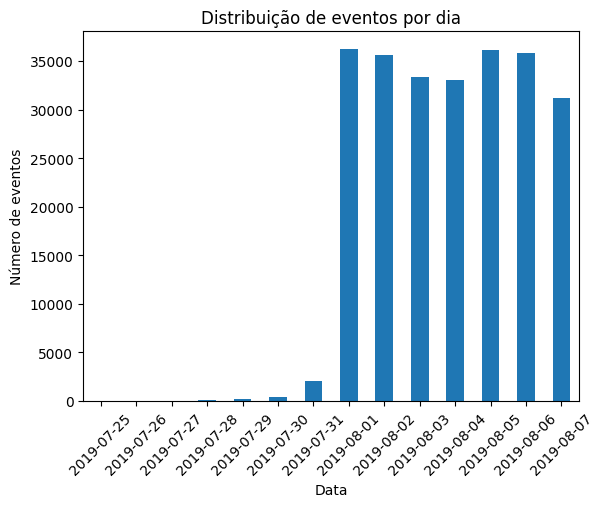

In [186]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

df['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição de eventos por dia')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()


Os dados começam a ter volume e consistencia a partir do dia 31/07

In [187]:
df = df[df['time'] >= '2019-07-31']
print(f'A menor data é {df['data'].min()} e a maior data é {df['data'].max()} um total de {df['data'].max() - df['data'].min()} ')

A menor data é 2019-07-31 e a maior data é 2019-08-07 um total de 7 days, 0:00:00 


In [188]:
print(f'{df.shape[0] -  df2.shape[0]} linhas de {df.shape[0]} foram perdidas.')

0 linhas de 243329 foram perdidas.


não foram muitos eventos e usuários. 

In [189]:
df.groupby('group')['id'].count()

C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1343537145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('group')['id'].count()


group
A1    80045
A2    77811
B     85473
Name: id, dtype: int64

Tem bastantes usuários de todos os 3 grupos.

In [190]:
df['event'].value_counts()


event
MainScreenAppear           118681
OffersScreenAppear          46724
CartScreenAppear            42623
PaymentScreenSuccessful     34253
Tutorial                     1048
Name: count, dtype: int64

In [191]:
# Total de usuários únicos no dataset
total_usuarios = df['id'].nunique()

# Número de usuários únicos por evento
usuarios_por_evento = df.groupby('event')['id'].nunique().sort_values(ascending=False)

# Proporção de usuários por evento
proporcao_usuarios = usuarios_por_evento / total_usuarios

# Juntando em um DataFrame com porcentagem formatada
resultado = pd.DataFrame({
    'usuarios_unicos': usuarios_por_evento,
    'proporcao (%)': proporcao_usuarios.map(lambda x: f'{x:.1%}')
})

print(resultado)


                         usuarios_unicos proporcao (%)
event                                                 
MainScreenAppear                    7429         98.5%
OffersScreenAppear                  4606         61.1%
CartScreenAppear                    3742         49.6%
PaymentScreenSuccessful             3542         47.0%
Tutorial                             845         11.2%


C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\3818876811.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usuarios_por_evento = df.groupby('event')['id'].nunique().sort_values(ascending=False)


1- MainScreenAppear — Tela principal apareceu

2- OffersScreenAppear — Tela de ofertas apareceu

3- CartScreenAppear — Tela do carrinho apareceu

 Tutorial — Tutorial exibido

4- PaymentScreenSuccessful — Pagamento realizado com sucesso

Nessa ordem tudo faz parte do caminho que o usuario faz até a o pagamento. O tutorial especificamente seria para a primeira compra do usuario, um caminho do q fazer para efetuar uma compra.  

In [192]:
# Lista com a sequência dos eventos
eventos_funnel = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Dicionário para armazenar os conjuntos de usuários de cada etapa
usuarios_por_evento = {}

# Obtemos o conjunto de usuários únicos por evento
for evento in eventos_funnel:
    usuarios_por_evento[evento] = set(df[df['event'] == evento]['id'].unique())

# Agora calculamos as proporções de avanço entre etapas
for i in range(len(eventos_funnel) - 1):
    etapa_atual = eventos_funnel[i]
    proxima_etapa = eventos_funnel[i + 1]
    
    usuarios_atual = usuarios_por_evento[etapa_atual]
    usuarios_proxima = usuarios_por_evento[proxima_etapa]
    
    # Apenas os que estão na próxima etapa e fizeram a anterior
    usuarios_que_avancaram = usuarios_atual & usuarios_proxima
    
    proporcao = len(usuarios_que_avancaram) / len(usuarios_atual) if len(usuarios_atual) > 0 else 0
    
    print(f"De '{etapa_atual}' para '{proxima_etapa}': {proporcao:.2%} ({len(usuarios_que_avancaram)} de {len(usuarios_atual)})")


De 'MainScreenAppear' para 'OffersScreenAppear': 60.53% (4497 de 7429)
De 'OffersScreenAppear' para 'CartScreenAppear': 80.00% (3685 de 4606)
De 'CartScreenAppear' para 'PaymentScreenSuccessful': 94.52% (3537 de 3742)


# Qual fase perde mais usuários
Na primeira faze perde-se mais usuários, entra a tela principal para a tela de ofertas.

In [193]:
# Ordem esperada de eventos (o funil completo)
sequencia_esperada = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Agrupar eventos por usuário em ordem cronológica
eventos_por_usuario = df.sort_values('time').groupby('id')['event'].apply(list)

# Verifica se a sequência esperada está contida nos eventos do usuário
def contem_toda_a_sequencia(eventos):
    i = 0
    for evento in eventos:
        if evento == sequencia_esperada[i]:
            i += 1
            if i == len(sequencia_esperada):
                return True
    return False

# Aplicar a função a todos os usuários
usuarios_com_caminho_completo = eventos_por_usuario.apply(contem_toda_a_sequencia)

# Número de usuários com o caminho completo
total_completo = usuarios_com_caminho_completo.sum()

# Total de usuários únicos
total_usuarios = df['id'].nunique()

# Proporção
proporcao = total_completo / total_usuarios

print(f"🧍 Usuários que fizeram o caminho inteiro: {total_completo}")
print(f"👥 Total de usuários únicos: {total_usuarios}")
print(f"📊 Proporção: {proporcao:.2%}")


🧍 Usuários que fizeram o caminho inteiro: 2974
👥 Total de usuários únicos: 7542
📊 Proporção: 39.43%


In [194]:
df.groupby('group')['id'].count()

C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1343537145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('group')['id'].count()


group
A1    80045
A2    77811
B     85473
Name: id, dtype: int64

In [195]:
# Define o evento de interesse para a análise
evento = 'PaymentScreenSuccessful'

# Conta quantos usuários únicos de cada grupo (A1 e A2) fizeram esse evento
fez_evento = df[df['event'] == evento].groupby('group')['id'].nunique()

# Conta o total de usuários únicos de cada grupo (independentemente do evento)
total = df.groupby('group')['id'].nunique()

# Calcula a proporção de usuários que fizeram o evento em cada grupo
p1, p2 = fez_evento['A1'] / total['A1'], fez_evento['A2'] / total['A2']

# Calcula a proporção combinada dos dois grupos (para usar no erro padrão)
p_comb = (fez_evento['A1'] + fez_evento['A2']) / (total['A1'] + total['A2'])

# Calcula o erro padrão da diferença entre duas proporções
se = (p_comb * (1 - p_comb) * (1/total['A1'] + 1/total['A2'])) ** 0.5

# Calcula o valor da estatística z (teste de hipótese)
z = (p1 - p2) / se

# Calcula o p-valor (probabilidade de observar uma diferença igual ou maior se não houver diferença real)
p_valor = 2 * (1 - st.norm.cdf(abs(z)))

# Exibe os resultados: quantidade de usuários por grupo que fizeram o evento, proporções e estatísticas
print(f'A1: {fez_evento["A1"]}/{total["A1"]}, A2: {fez_evento["A2"]}/{total["A2"]}')
print(f'Proporções → A1: {p1:.4f}, A2: {p2:.4f}')
print(f'z = {z:.4f}, p = {p_valor:.4f}')

# Interpreta o resultado: verifica se há diferença estatística significativa entre os grupos
print("→ Diferença significativa" if p_valor < 0.05 else "→ Sem diferença significativa (A/A OK)")


A1: 1200/2485, A2: 1159/2517
Proporções → A1: 0.4829, A2: 0.4605
z = 1.5888, p = 0.1121
→ Sem diferença significativa (A/A OK)


C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1085282885.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fez_evento = df[df['event'] == evento].groupby('group')['id'].nunique()
C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1085282885.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df.groupby('group')['id'].nunique()


In [196]:
# 1) Prepara os grupos A1 e A2 (renomeando os valores de 'group' se necessário)
df_ctl = df 
# Total de usuários únicos por grupo
totais = df_ctl.groupby('group')['id'].nunique()

# Função para calcular o teste z de duas proporções
def z_test_prop(k1, n1, k2, n2):
    # Proporção combinada
    p_comb = (k1 + k2) / (n1 + n2)
    # Erro padrão da diferença de proporções
    se = np.sqrt(p_comb * (1 - p_comb) * (1/n1 + 1/n2))
    # Estatística z
    z = (k1/n1 - k2/n2) / se
    # P-valor bicaudal
    p = 2 * (1 - st.norm.cdf(abs(z)))
    return z, p

# 2) Identifica o evento mais popular (com maior número de usuários)
contagem_eventos = df_ctl.groupby('event')['id'].nunique().sort_values(ascending=False)
evento_mais_popular = contagem_eventos.index[0]

# 3) Para o evento mais popular, conta os usuários únicos em A1 e A2
k1 = df_ctl[(df_ctl['group']=='A1') & (df_ctl['event']==evento_mais_popular)]['id'].nunique()
k2 = df_ctl[(df_ctl['group']=='A2') & (df_ctl['event']==evento_mais_popular)]['id'].nunique()
n1, n2 = totais['A1'], totais['A2']

# Testa a diferença de proporções para todos os eventos
resultados = []
for ev in contagem_eventos.index:
    # Contagem dos usuários que realizaram o evento para A1 e A2
    k1 = df_ctl[(df_ctl['group']=='A1') & (df_ctl['event']==ev)]['id'].nunique()
    k2 = df_ctl[(df_ctl['group']=='A2') & (df_ctl['event']==ev)]['id'].nunique()
    # Calcula o z-test
    z, p = z_test_prop(k1, n1, k2, n2)
    # Adiciona os resultados à lista
    resultados.append((ev, k1, k2, f"{k1/n1:.2%}", f"{k2/n2:.2%}", round(p, 3)))

# Cria um DataFrame para organizar e visualizar os resultados
res_df = pd.DataFrame(resultados, columns=['event', 'A1_users', 'A2_users', 'A1_%', 'A2_%', 'p_value'])
print(res_df)

# 4) Verifica se os grupos estão bem balanceados
if (res_df['p_value'] >= 0.05).all():
    print("\n✅ Todos os eventos apresentam p ≥ 0.05 → grupos A1 e A2 parecem bem balanceados (teste A/A válido).")
else:
    print("\n⚠️ Há pelo menos um evento com p < 0.05 → possível desequilíbrio entre A1 e A2.")


                     event  A1_users  A2_users    A1_%    A2_%  p_value
0         MainScreenAppear      2452      2479  98.67%  98.49%    0.587
1       OffersScreenAppear      1544      1526  62.13%  60.63%    0.274
2         CartScreenAppear      1267      1239  50.99%  49.23%    0.213
3  PaymentScreenSuccessful      1200      1159  48.29%  46.05%    0.112
4                 Tutorial       278       285  11.19%  11.32%    0.879

✅ Todos os eventos apresentam p ≥ 0.05 → grupos A1 e A2 parecem bem balanceados (teste A/A válido).


C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1512337063.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totais = df_ctl.groupby('group')['id'].nunique()
C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\1512337063.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contagem_eventos = df_ctl.groupby('event')['id'].nunique().sort_values(ascending=False)


In [200]:

# 1) Prepara o DataFrame com A1, A2 e B
df_exp = df

# 2) Totais de usuários únicos por grupo
totais = df_exp.groupby('group')['id'].nunique()
total_comb = totais['A1'] + totais['A2']

# 3) Função de teste z de duas proporções (retorna p-valor)
def z_test(k1, n1, k2, n2):
    p_comb = (k1 + k2) / (n1 + n2)
    se = np.sqrt(p_comb * (1 - p_comb) * (1/n1 + 1/n2))
    z = (k1/n1 - k2/n2) / se
    return 2 * (1 - st.norm.cdf(abs(z)))

# 4) Monta a tabela
resultados = []
for ev in df_exp['event'].unique():
    kA1 = df_exp[(df_exp['group']=='A1') & (df_exp['event']==ev)]['id'].nunique()
    kA2 = df_exp[(df_exp['group']=='A2') & (df_exp['event']==ev)]['id'].nunique()
    kB  = df_exp[(df_exp['group']=='B')  & (df_exp['event']==ev)]['id'].nunique()
    pA1, pA2, pB = kA1/totais['A1'], kA2/totais['A2'], kB/totais['B']
    
    resultados.append({
        'event':      ev,
        'A1_users':   kA1,    'A2_users':   kA2,    'B_users':    kB,
        'A1_%':       f'{pA1:.2%}', 'A2_%': f'{pA2:.2%}', 'B_%': f'{pB:.2%}',
        'p_A1_vs_B':  round(z_test(kA1, totais['A1'], kB, totais['B']), 3),
        'p_A2_vs_B':  round(z_test(kA2, totais['A2'], kB, totais['B']), 3),
        'p_comb_vs_B':round(z_test(kA1+kA2, total_comb, kB, totais['B']), 3)
    })

tabela = pd.DataFrame(resultados).sort_values('event')
print(tabela)
# Supondo que sua tabela final se chame `tabela`
mask_sem_diferenca = (
    (tabela['p_A1_vs_B']  >= 0.05) &
    (tabela['p_A2_vs_B']  >= 0.05) &
    (tabela['p_comb_vs_B']>= 0.05)
)

if mask_sem_diferenca.all():
    print("\n✅ Todos os eventos têm p ≥ 0.05 em A1 vs B, A2 vs B e combinado vs B → grupos bem balanceados; nenhuma diferença significativa.")
else:
    print("\n⚠️ Há pelo menos um evento com p < 0.05 em alguma comparação → possível efeito do tratamento ou desequilíbrio na randomização.")


                     event  A1_users  A2_users  B_users    A1_%    A2_%  \
4         CartScreenAppear      1267      1239     1236  50.99%  49.23%   
0         MainScreenAppear      2452      2479     2498  98.67%  98.49%   
1       OffersScreenAppear      1544      1526     1536  62.13%  60.63%   
3  PaymentScreenSuccessful      1200      1159     1183  48.29%  46.05%   
2                 Tutorial       278       285      282  11.19%  11.32%   

      B_%  p_A1_vs_B  p_A2_vs_B  p_comb_vs_B  
4  48.66%      0.099      0.688        0.238  
0  98.35%      0.341      0.682        0.429  
1  60.47%      0.227      0.910        0.447  
3  46.57%      0.224      0.707        0.630  
2  11.10%      0.924      0.804        0.842  

✅ Todos os eventos têm p ≥ 0.05 em A1 vs B, A2 vs B e combinado vs B → grupos bem balanceados; nenhuma diferença significativa.


C:\Users\jonat\AppData\Local\Temp\ipykernel_16848\997521166.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totais = df_exp.groupby('group')['id'].nunique()


Nenhum p-valor fica abaixo de 0.05, em nenhuma das três comparações para qualquer evento.

Isso significa que não há diferença estatisticamente significativa entre o grupo de fontes alteradas (B) e nenhum dos grupos de controle (A1, A2 ou A1 + A2) em termos da proporção de usuários que executaram cada evento.
# Conclusões do experimento

A randomização dos usuários parece ter funcionado corretamente: os três grupos são estatisticamente equivalentes para todas as ações medida

In [203]:
alpha = 0.1

if (res_df['p_value'] >= alpha).all():
    print(f"\n✅ Todos os eventos apresentam p ≥ {alpha} → grupos A1 e A2 parecem bem balanceados (teste A/A válido).")
else:
    print(f"\n⚠️ Há pelo menos um evento com p < {alpha} → possível desequilíbrio entre A1 e A2.")


mask_sem_diferenca = (
    (tabela['p_A1_vs_B']  >= alpha) &
    (tabela['p_A2_vs_B']  >= alpha) &
    (tabela['p_comb_vs_B']>= alpha)
)

if mask_sem_diferenca.all():
    print(f"\n✅ Todos os eventos têm p ≥ {alpha} em A1 vs B, A2 vs B e combinado vs B → grupos bem balanceados; nenhuma diferença significativa.")
else:
    print(f"\n⚠️ Há pelo menos um evento com p < {alpha} em alguma comparação → possível efeito do tratamento ou desequilíbrio na randomização.")


✅ Todos os eventos apresentam p ≥ 0.1 → grupos A1 e A2 parecem bem balanceados (teste A/A válido).

⚠️ Há pelo menos um evento com p < 0.1 em alguma comparação → possível efeito do tratamento ou desequilíbrio na randomização.


Em cada um dos comparativos (A1 vs A2, A1 vs B, A2 vs B e combinado vs B), foi utilizado um nível de significância de α = 0,1 para rejeição da hipótese nula (H₀). Esse valor indica que estamos aceitando até 10% de chance de cometer um erro tipo I em cada teste isolado.
Foram analisados 5 eventos, com 3 comparações realizadas em cada um (A1 vs B, A2 vs B e A1+A2 vs B), totalizando 15 testes estatísticos.

Isso significa que, com α = 0,1, existe uma chance de até 10% de rejeitar uma hipótese nula verdadeira em cada teste, o que aumenta a probabilidade de pelo menos um falso positivo ao realizar múltiplos testes.

Para controlar o erro global, uma alternativa é aplicar o ajuste de Bonferroni: α corrigido = 0,05 / 15 ≈ 0,0033 por teste. Outra possibilidade é usar o método de controle da FDR, como Benjamini-Hochberg, que é menos conservador e busca equilibrar descobertas verdadeiras com o risco de falsos positivos.

Caso decida aplicar um nível de significância ajustado (como 0,0033), será necessário refazer todos os testes e verificar se os p-valores permanecem abaixo do novo limiar. Isso indicará se ainda há diferenças estatisticamente significativas.

## Conclusão

Após a análise detalhada dos logs de eventos do teste A/B, podemos tirar as seguintes conclusões:

1.  **Pré-processamento e Análise Exploratória:** Os dados foram carregados, limpos e preparados adequadamente. A análise exploratória revelou um funil de eventos claro (`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`), com a maior taxa de abandono ocorrendo na primeira transição. Cerca de 39% dos usuários que iniciaram o funil completaram o pagamento. Os dados mostraram maior consistência a partir de 31/07/2019, mas a análise utilizou o conjunto completo devido à perda mínima de dados ao filtrar.

2.  **Validação do Teste A/A:** A comparação entre os grupos de controle A1 e A2 (teste A/A) não mostrou diferenças estatisticamente significativas nas proporções de usuários para nenhum dos eventos analisados, utilizando o **nível de significância α = 0,1** definido para cada teste individual (todos os p-valores foram maiores que 0,1). Isso confirma que os grupos de controle eram homogêneos e que a divisão dos usuários foi feita corretamente, validando a configuração do experimento.

3.  **Resultados do Teste A/B:** A comparação do grupo de teste B (com a nova fonte) contra os grupos de controle A1, A2 e o combinado (A1+A2) também não revelou diferenças estatisticamente significativas em nenhuma das etapas do funil. Todos os p-valores calculados para as 15 comparações A/B foram **superiores ao nível de significância α = 0,1**.

4.  **Impacto da Mudança de Fonte:** Com base nos resultados dos testes estatísticos (utilizando um nível de significância **α = 0,1 por teste**), **não há evidências estatísticas para concluir que a alteração da fonte no aplicativo teve um impacto mensurável** na proporção de usuários que progridem através das principais etapas do funil de compra durante o período analisado. A mudança parece ser neutra em relação a essas métricas.

5.  **Considerações sobre Testes Múltiplos e Nível de Significância:** Foi utilizado um nível de significância de **α = 0,1** para cada teste individual. Foram realizados 15 testes estatísticos independentes nas comparações A/B (5 eventos x 3 comparações). Embora usar α = 0,1 aumente a chance de erro Tipo I (rejeitar H₀ quando ela é verdadeira) para 10% em cada teste, a realização de múltiplos testes eleva a probabilidade acumulada de ocorrer pelo menos um falso positivo (erro familiar). Métodos como a correção de Bonferroni (α corrigido ≈ 0,0033) ou o controle da Taxa de Falsas Descobertas (FDR) poderiam ser usados para mitigar esse risco. No entanto, como **nenhum dos p-valores individuais sequer se aproximou do limiar inicial de 0,1**, a aplicação dessas correções mais rigorosas não alteraria a conclusão principal. A ausência de significância estatística, mesmo sob um critério individual menos estrito (α = 0,1), reforça a conclusão de que a mudança de fonte provavelmente não teve um efeito detectável.

Portanto, o experimento indica fortemente que a alteração da fonte é neutra em relação ao comportamento do usuário no funil de compras principal, conforme medido pelas proporções de conversão entre etapas.